<a href="https://colab.research.google.com/github/marystovall/Data-Analysis/blob/master/CDL_Website_Semantic_Audit_by_WordLift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Audit

<table align="left">
  <td>
  <a href="https://wordlift.io">
    <img width=130px src="https://wordlift.io/wp-content/uploads/2018/07/logo-assets-510x287.png" />
    </a>
    </td>
    <td>
     <img width=130px src="https://cdn.oreillystatic.com/oreilly/images/logo_guidelines_bg_white.png"  /> 
    </td>
    <td>
      by 
      <a href="https://wordlift.io/blog/en/entity/andrea-volpini">
        Andrea Volpini
      </a>
      <br/>
      <br/>
      MIT License
      <br/>
      <br/>
      <i>Last updated: <b>Sept 8th, 2019</b></i>
  </td>
</table>

Using **[spaCy](https://spacy.io)** (a great library for *natural language processing*) **to extract named entities** from a list of urls *(this list can be generated using your favorite crawler)*.


> For more information on **[natural language processing for SEO](https://wordlift.io/blog/en/entity/natural-language-processing/)**, you can visit the WordLift blog.


## Importing the libraries we need




In [0]:
# Import libraries
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Use the following for threading 
import logging
#import os
#from queue import Queue
#from threading import Thread
from time import time

## Downloading crawl data from Google Sheet 

The script uses the `internal_html` CSV export file generated using **Screaming FROG Seo Spider** or `_url` CSV file generated with **WooRank Crawler**. 

The data has been imported into Google Sheet so that we can inspect it. Change the URL below after publishing your CSV:


> 1. Open file from "My Drive" or "Upload"
2. File -> Publish to the web -> "Sheet name" option and "csv" option




In [0]:
# Download the list of URLs from Google Docs (file generated with Screaming Frog SEO Spider) 
!wget 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSipACDZxAX8rBejVGrtC_kvwgcVERVXTLh4ng-bklobTw7eA-y7iNDyvWqLi5-d2fESrCrLu5ama21/pub?gid=62665702&single=true&output=csv'



--2019-10-03 13:39:15--  https://docs.google.com/spreadsheets/d/e/2PACX-1vSipACDZxAX8rBejVGrtC_kvwgcVERVXTLh4ng-bklobTw7eA-y7iNDyvWqLi5-d2fESrCrLu5ama21/pub?gid=62665702&single=true&output=csv
Resolving docs.google.com (docs.google.com)... 74.125.195.138, 74.125.195.102, 74.125.195.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘pub?gid=62665702&single=true&output=csv’

pub?gid=62665702&si     [ <=>                ]  15.80K  --.-KB/s    in 0s      

2019-10-03 13:39:16 (88.0 MB/s) - ‘pub?gid=62665702&single=true&output=csv’ saved [16183]



In [0]:
# Download the list of URLs from Google Docs (file generated with WooRank) 
!wget 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQEwgTFGA4j23334Q1Cd89aui0kbHcPUf9yNz1wvz5pCIDq2smAzn71Z2SMPFUiRYWy0DblpQq_QM4A/pub?gid=388657239&single=true&output=csv'


## Creating a Pandas DataFrame 

Following the file structure we will only use the following columns:

- *url* (`cols='0'` | `Address`), 
- *http status* (`cols='2'` | `Status Code`), 
- *title* (`cols='6'` | `Title 1`)

We will then use *http status* to focus our analysis only to urls responding with `HTTP 200`.

In [0]:
# Open the CSV file with the URLs to analyze

df = pd.read_csv('pub?gid=62665702&single=true&output=csv', # Update the string here to change the file
                  usecols=[0,2,6], # This is for Screaming Frog
                 #usecols=[0,5,8,38],  
                 header=1,
                 encoding="utf-8-sig" ) 

print("we have a total of:", len(df), " urls")

df.head()

we have a total of: 19  urls


,Address,Status Code,Title 1
0,https://open-data.insideout.io/,200,connected-data.london – Workshop – AI-Powered SEO
1,https://open-data.insideout.io/2018/12/11/the-...,200,The Future of Data is Connected and Open Minde...
2,https://open-data.insideout.io/2019/07/01/life...,200,Life Sciences at Connected Data London 2019 – ...
3,https://open-data.insideout.io/category/uncate...,200,Uncategorized – connected-data.london – Workshop
4,https://open-data.insideout.io/2018/11/05/deep...,200,Deep link analysis drives machine learning at ...


In [0]:
# WooRank - Keep all rows with Status Code == 200 considered PAGE and with GSC position >=1 
df = df[(df['status'] == 200) & (df['parent_type'] == 'PAGE') & (df['position'] >= 1)] 


In [0]:
# Screaming Frog - Keep all rows with Status Code == 200 and exclude archive pages
df = df[(df['Status Code'] == 200) & (df['Address'].str.contains("category")==False)]

In [0]:
print("we have to process:", len(df), " urls")

# Reindex df
df.index = range(len(df.index))

we have to process: 17  urls


In [0]:
df.head()

,Address,Status Code,Title 1
0,https://open-data.insideout.io/,200,connected-data.london – Workshop – AI-Powered SEO
1,https://open-data.insideout.io/2018/12/11/the-...,200,The Future of Data is Connected and Open Minde...
2,https://open-data.insideout.io/2019/07/01/life...,200,Life Sciences at Connected Data London 2019 – ...
3,https://open-data.insideout.io/2018/11/05/deep...,200,Deep link analysis drives machine learning at ...
4,https://open-data.insideout.io/2019/03/08/more...,200,"More Connected, More Data, More London: Connec..."


In [0]:
# Creating df_new with the columns we need to store entity data

df_new = pd.DataFrame(columns=['url', 'entities', 'types', 'total'])


## Running the analysis 

In the next cells we have two functions:



1.   `url_to_string` to get the text from a URL (make sure to update this one if you know the class that contains the body of the article) 
2.   `string_to_entities` to extract the named entities

We will also test the extraction before analyzing the entire batch of URLs. 

> In the future the loop should take advantages of *threading* as it gets otherwise too slow when you have thousands of pages.


In [0]:
# Get clean text from URL

def url_to_string(url):
  try:
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:50.0) Gecko/20100101 Firefox/50.0'}
    res = requests.get(url, headers=headers)
    html = res.text
    soup = BeautifulSoup(html, 'html5lib')
    for script in soup(["script", "style", 'aside']):
        script.extract()
    
    # uncomment the lines in the if/else block and comment the one after if you know the name of the class containing the article body 
    if isinstance(soup.find('div', {'class' :'content-inner'}), type(None)):
      return " ".join(re.split(r'[\n\t]+', soup.get_text()))
    else:
      return " ".join(re.split(r'[\n\t]+', soup.find('div', {'class' :'content-inner'}).text)) 
    
    #return " ".join(re.split(r'[\n\t]+', soup.get_text()))

  except requests.exceptions.HTTPError as err:
    print(err)
    sys.exit(1)
    return err


In [0]:
# Analyze text with SpaCy for named entity recognition

def string_to_entities(text): 
  #ny_bb = url_to_string(nw_url)
  article = nlp(text)
  print("total number of entities:", len(article.ents))
  entity_data = [(x.text, x.label_) for x in article.ents]
  return entity_data  

### Choose a URL to run a test 

We will use here the entity visualizer, `ent`, highlights named entities and their labels in a text.

Set the `url_test` variable to see how it works.  

In [0]:
# Visualizing detected entities from a single URL

url_test = "https://connected-data.london/sessions/from-knowledge-graphs-to-ai-powered-seo-using-taxonomies-schemas-and-knowledge-graphs-to-improve-search-engine-rankings-and-web-publishing-workflows/" # pick up any url you like to analyze


doc1 = nlp(url_to_string(url_test))
print("total number of entities:", len(doc1.ents))

displacy.render(doc1, style="ent", jupyter=True)





total number of entities: 84


In [0]:
# Analyze each URL and store top 5 entities for each article

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

logger = logging.getLogger(__name__)
ts = time()

for k in range(len(df)): 

#for k in range(5): # Use this to analyze only a limited number of pages
    
    nw_url = df.loc[k][0]
    print(nw_url)
    
    # Get text from URLs  
    ny_bb = url_to_string(nw_url)
    
    # Extract entities from the text
    data_x = string_to_entities(ny_bb)

    # Get the top five entities for each URL
    ls = list((Counter(data_x).most_common(5)))
    
    # Store data in df_new
    for y,w in ls:
      print(nw_url, y,w)
    
      # Add new row containing url, entities, types and total count
      df_new = df_new.append({'url': nw_url, 'entities': y[0], 'types': y[1],'total': w}, ignore_index=True)
          
    print(k, "/", len(df))
    
    # Add some logging
    logging.info('Took %s', time() - ts)


https://open-data.insideout.io/


2019-10-03 13:47:31,074 - root - INFO - Took 2.9556660652160645


total number of entities: 833
https://open-data.insideout.io/ ('Knowledge Graphs', 'PERSON') 20
https://open-data.insideout.io/ ('London', 'GPE') 20
https://open-data.insideout.io/ ('2019', 'DATE') 19
https://open-data.insideout.io/ ('Connected Data', 'ORG') 19
https://open-data.insideout.io/ ('Siren', 'ORG') 18
0 / 17
https://open-data.insideout.io/2018/12/11/the-future-of-data-is-connected-and-open-minded/


2019-10-03 13:47:32,121 - root - INFO - Took 4.00358510017395


total number of entities: 135
https://open-data.insideout.io/2018/12/11/the-future-of-data-is-connected-and-open-minded/ ('Knowledge Graphs', 'PERSON') 9
https://open-data.insideout.io/2018/12/11/the-future-of-data-is-connected-and-open-minded/ ('Linked Data', 'ORG') 5
https://open-data.insideout.io/2018/12/11/the-future-of-data-is-connected-and-open-minded/ ('one', 'CARDINAL') 5
https://open-data.insideout.io/2018/12/11/the-future-of-data-is-connected-and-open-minded/ ('today', 'DATE') 3
https://open-data.insideout.io/2018/12/11/the-future-of-data-is-connected-and-open-minded/ ('London', 'GPE') 3
1 / 17
https://open-data.insideout.io/2019/07/01/life-sciences-at-connected-data-london-2019/


2019-10-03 13:47:32,958 - root - INFO - Took 4.840188026428223


total number of entities: 66
https://open-data.insideout.io/2019/07/01/life-sciences-at-connected-data-london-2019/ ('Connected Data', 'ORG') 4
https://open-data.insideout.io/2019/07/01/life-sciences-at-connected-data-london-2019/ ('Life Sciences', 'ORG') 4
https://open-data.insideout.io/2019/07/01/life-sciences-at-connected-data-london-2019/ ('London', 'GPE') 3
https://open-data.insideout.io/2019/07/01/life-sciences-at-connected-data-london-2019/ ('Connected Data London', 'ORG') 3
https://open-data.insideout.io/2019/07/01/life-sciences-at-connected-data-london-2019/ ('2019', 'CARDINAL') 2
2 / 17
https://open-data.insideout.io/2018/11/05/deep-link-analysis-drives-machine-learning-at-massive-scale/


2019-10-03 13:47:34,086 - root - INFO - Took 5.968474388122559


total number of entities: 124
https://open-data.insideout.io/2018/11/05/deep-link-analysis-drives-machine-learning-at-massive-scale/ ('three', 'CARDINAL') 10
https://open-data.insideout.io/2018/11/05/deep-link-analysis-drives-machine-learning-at-massive-scale/ ('TigerGraph', 'ORG') 7
https://open-data.insideout.io/2018/11/05/deep-link-analysis-drives-machine-learning-at-massive-scale/ ('’s', 'GPE') 7
https://open-data.insideout.io/2018/11/05/deep-link-analysis-drives-machine-learning-at-massive-scale/ ('John', 'PERSON') 7
https://open-data.insideout.io/2018/11/05/deep-link-analysis-drives-machine-learning-at-massive-scale/ ('Tim', 'PERSON') 6
3 / 17
https://open-data.insideout.io/2019/03/08/more-connected-more-data-more-london-connected-data-london-2019/


2019-10-03 13:47:34,627 - root - INFO - Took 6.5091681480407715


total number of entities: 133
https://open-data.insideout.io/2019/03/08/more-connected-more-data-more-london-connected-data-london-2019/ ('London', 'GPE') 9
https://open-data.insideout.io/2019/03/08/more-connected-more-data-more-london-connected-data-london-2019/ ('2019', 'DATE') 7
https://open-data.insideout.io/2019/03/08/more-connected-more-data-more-london-connected-data-london-2019/ ('CDL', 'ORG') 4
https://open-data.insideout.io/2019/03/08/more-connected-more-data-more-london-connected-data-london-2019/ ('SEO', 'ORG') 3
https://open-data.insideout.io/2019/03/08/more-connected-more-data-more-london-connected-data-london-2019/ ('Microsoft', 'ORG') 3
4 / 17
https://open-data.insideout.io/page/2/


2019-10-03 13:47:35,947 - root - INFO - Took 7.8287975788116455


total number of entities: 185
https://open-data.insideout.io/page/2/ ('KeyLines', 'ORG') 34
https://open-data.insideout.io/page/2/ ('OpenRefine', 'ORG') 11
https://open-data.insideout.io/page/2/ ('GraphDB', 'CARDINAL') 8
https://open-data.insideout.io/page/2/ ('GraphDB', 'DATE') 8
https://open-data.insideout.io/page/2/ ('SPARQL', 'ORG') 5
5 / 17
https://open-data.insideout.io/2019/06/03/the-future-is-graph-knowledge-graph-connected-data-london-is-where-you-get-your-graph-knowledge/


2019-10-03 13:47:36,802 - root - INFO - Took 8.683933734893799


total number of entities: 109
https://open-data.insideout.io/2019/06/03/the-future-is-graph-knowledge-graph-connected-data-london-is-where-you-get-your-graph-knowledge/ ('Microsoft', 'ORG') 7
https://open-data.insideout.io/2019/06/03/the-future-is-graph-knowledge-graph-connected-data-london-is-where-you-get-your-graph-knowledge/ ('Connected Data', 'ORG') 5
https://open-data.insideout.io/2019/06/03/the-future-is-graph-knowledge-graph-connected-data-london-is-where-you-get-your-graph-knowledge/ ('2019', 'DATE') 5
https://open-data.insideout.io/2019/06/03/the-future-is-graph-knowledge-graph-connected-data-london-is-where-you-get-your-graph-knowledge/ ('Joshua', 'PERSON') 4
https://open-data.insideout.io/2019/06/03/the-future-is-graph-knowledge-graph-connected-data-london-is-where-you-get-your-graph-knowledge/ ('London', 'GPE') 3
6 / 17
https://open-data.insideout.io/2019/05/01/how-graphs-continue-to-revolutionise-the-prevention-of-financial-crime-fraud-in-real-time/


2019-10-03 13:47:37,241 - root - INFO - Took 9.123524904251099


total number of entities: 89
https://open-data.insideout.io/2019/05/01/how-graphs-continue-to-revolutionise-the-prevention-of-financial-crime-fraud-in-real-time/ ('TigerGraph', 'ORG') 4
https://open-data.insideout.io/2019/05/01/how-graphs-continue-to-revolutionise-the-prevention-of-financial-crime-fraud-in-real-time/ ('Graphs', 'PERSON') 3
https://open-data.insideout.io/2019/05/01/how-graphs-continue-to-revolutionise-the-prevention-of-financial-crime-fraud-in-real-time/ ('one', 'CARDINAL') 3
https://open-data.insideout.io/2019/05/01/how-graphs-continue-to-revolutionise-the-prevention-of-financial-crime-fraud-in-real-time/ ('OpenCorporates', 'ORG') 3
https://open-data.insideout.io/2019/05/01/how-graphs-continue-to-revolutionise-the-prevention-of-financial-crime-fraud-in-real-time/ ('GSQL', 'ORG') 3
7 / 17
https://open-data.insideout.io/2019/09/22/leverage-your-enterprise-data-with-knowledge-graphs-without-changing-everything/


2019-10-03 13:47:38,206 - root - INFO - Took 10.088030576705933


total number of entities: 132
https://open-data.insideout.io/2019/09/22/leverage-your-enterprise-data-with-knowledge-graphs-without-changing-everything/ ('Siren', 'ORG') 17
https://open-data.insideout.io/2019/09/22/leverage-your-enterprise-data-with-knowledge-graphs-without-changing-everything/ ('Knowledge Graphs', 'PERSON') 6
https://open-data.insideout.io/2019/09/22/leverage-your-enterprise-data-with-knowledge-graphs-without-changing-everything/ ('Siren ML', 'ORG') 6
https://open-data.insideout.io/2019/09/22/leverage-your-enterprise-data-with-knowledge-graphs-without-changing-everything/ ('10.3', 'CARDINAL') 3
https://open-data.insideout.io/2019/09/22/leverage-your-enterprise-data-with-knowledge-graphs-without-changing-everything/ ('UI', 'ORG') 3
8 / 17
https://open-data.insideout.io/author/cyberandy/


2019-10-03 13:47:38,638 - root - INFO - Took 10.520023584365845


total number of entities: 95
https://open-data.insideout.io/author/cyberandy/ ('2019', 'DATE') 8
https://open-data.insideout.io/author/cyberandy/ ('Connected Data', 'ORG') 7
https://open-data.insideout.io/author/cyberandy/ ('London', 'GPE') 7
https://open-data.insideout.io/author/cyberandy/ ('Connected Data London', 'ORG') 5
https://open-data.insideout.io/author/cyberandy/ ('The Future of Data', 'ORG') 3
9 / 17
https://open-data.insideout.io/2019/08/11/connected-data-london-2019-program-announced-the-future-is-graph-knowledge-graph-connected-data-london-is-where-it-unfolds/


2019-10-03 13:47:39,430 - root - INFO - Took 11.311635971069336
2019-10-03 13:47:39,560 - root - INFO - Took 11.442017555236816


total number of entities: 103
https://open-data.insideout.io/2019/08/11/connected-data-london-2019-program-announced-the-future-is-graph-knowledge-graph-connected-data-london-is-where-it-unfolds/ ('London', 'GPE') 5
https://open-data.insideout.io/2019/08/11/connected-data-london-2019-program-announced-the-future-is-graph-knowledge-graph-connected-data-london-is-where-it-unfolds/ ('2019', 'DATE') 5
https://open-data.insideout.io/2019/08/11/connected-data-london-2019-program-announced-the-future-is-graph-knowledge-graph-connected-data-london-is-where-it-unfolds/ ('Connected Data London', 'ORG') 4
https://open-data.insideout.io/2019/08/11/connected-data-london-2019-program-announced-the-future-is-graph-knowledge-graph-connected-data-london-is-where-it-unfolds/ ('Graph', 'PERSON') 3
https://open-data.insideout.io/2019/08/11/connected-data-london-2019-program-announced-the-future-is-graph-knowledge-graph-connected-data-london-is-where-it-unfolds/ ('Data', 'ORG') 3
10 / 17
https://open-data.

2019-10-03 13:47:39,870 - root - INFO - Took 11.752009630203247


total number of entities: 27
https://open-data.insideout.io/2019/05/22/win-free-half-price-tickets-to-the-worlds-largest-developer-conference/ ('Connected Data', 'ORG') 2
https://open-data.insideout.io/2019/05/22/win-free-half-price-tickets-to-the-worlds-largest-developer-conference/ ('May 22, 2019October 3, 2019', 'DATE') 1
https://open-data.insideout.io/2019/05/22/win-free-half-price-tickets-to-the-worlds-largest-developer-conference/ ('Data', 'ORG') 1
https://open-data.insideout.io/2019/05/22/win-free-half-price-tickets-to-the-worlds-largest-developer-conference/ ('London', 'GPE') 1
https://open-data.insideout.io/2019/05/22/win-free-half-price-tickets-to-the-worlds-largest-developer-conference/ ('October the 3rd and 4th', 'DATE') 1
12 / 17
https://open-data.insideout.io/2019/05/13/connected-data-workshops-get-hands-on-knowledge-learn-from-the-best/


2019-10-03 13:47:40,199 - root - INFO - Took 12.08085823059082


total number of entities: 48
https://open-data.insideout.io/2019/05/13/connected-data-workshops-get-hands-on-knowledge-learn-from-the-best/ ('Connected Data', 'ORG') 3
https://open-data.insideout.io/2019/05/13/connected-data-workshops-get-hands-on-knowledge-learn-from-the-best/ ('Graphs', 'PERSON') 3
https://open-data.insideout.io/2019/05/13/connected-data-workshops-get-hands-on-knowledge-learn-from-the-best/ ('Andrea Volpini', 'PERSON') 2
https://open-data.insideout.io/2019/05/13/connected-data-workshops-get-hands-on-knowledge-learn-from-the-best/ ('Mark Needham', 'PERSON') 2
https://open-data.insideout.io/2019/05/13/connected-data-workshops-get-hands-on-knowledge-learn-from-the-best/ ('Victor Lee', 'PERSON') 2
13 / 17
https://open-data.insideout.io/2018/10/22/semantics-meet-data-science-graphdb-adds-support-for-data-wrangling-and-similarity-search/


2019-10-03 13:47:41,168 - root - INFO - Took 13.050288915634155


total number of entities: 96
https://open-data.insideout.io/2018/10/22/semantics-meet-data-science-graphdb-adds-support-for-data-wrangling-and-similarity-search/ ('OpenRefine', 'ORG') 11
https://open-data.insideout.io/2018/10/22/semantics-meet-data-science-graphdb-adds-support-for-data-wrangling-and-similarity-search/ ('GraphDB', 'CARDINAL') 9
https://open-data.insideout.io/2018/10/22/semantics-meet-data-science-graphdb-adds-support-for-data-wrangling-and-similarity-search/ ('GraphDB', 'DATE') 8
https://open-data.insideout.io/2018/10/22/semantics-meet-data-science-graphdb-adds-support-for-data-wrangling-and-similarity-search/ ('SPARQL', 'ORG') 5
https://open-data.insideout.io/2018/10/22/semantics-meet-data-science-graphdb-adds-support-for-data-wrangling-and-similarity-search/ ('Semantic Vectors', 'LOC') 4
14 / 17
https://open-data.insideout.io/author/cyberandy/page/2/


2019-10-03 13:47:41,916 - root - INFO - Took 13.797826766967773


total number of entities: 21
https://open-data.insideout.io/author/cyberandy/page/2/ ('KeyLines', 'ORG') 2
https://open-data.insideout.io/author/cyberandy/page/2/ ('Semantics', 'NORP') 2
https://open-data.insideout.io/author/cyberandy/page/2/ ('Data Science', 'ORG') 2
https://open-data.insideout.io/author/cyberandy/page/2/ ('GraphDB', 'CARDINAL') 2
https://open-data.insideout.io/author/cyberandy/page/2/ ('Page 2', 'ORG') 1
15 / 17
https://open-data.insideout.io/2018/10/24/visualizing-graphs-with-keylines-bringing-connected-data-to-life/


2019-10-03 13:47:42,850 - root - INFO - Took 14.732438564300537


total number of entities: 113
https://open-data.insideout.io/2018/10/24/visualizing-graphs-with-keylines-bringing-connected-data-to-life/ ('KeyLines', 'ORG') 35
https://open-data.insideout.io/2018/10/24/visualizing-graphs-with-keylines-bringing-connected-data-to-life/ ('Cambridge Intelligence', 'ORG') 4
https://open-data.insideout.io/2018/10/24/visualizing-graphs-with-keylines-bringing-connected-data-to-life/ ('JavaScript', 'ORG') 3
https://open-data.insideout.io/2018/10/24/visualizing-graphs-with-keylines-bringing-connected-data-to-life/ ('SDK', 'ORG') 2
https://open-data.insideout.io/2018/10/24/visualizing-graphs-with-keylines-bringing-connected-data-to-life/ ('JSON', 'ORG') 2
16 / 17


## Storing the data

In the following cells we are going to: 

1.   Save a CSV containing url, entities, types and total 
2.   Filter only entities belonging to specific types (see [here](https://spacy.io/api/annotation#named-entities) for the complete list)
3.   Get the top 1.000 entities by the number of occurrences in the entire text corpus (all the scanned pages)
4.   Saving the top 1.000 entities to a CSV 
5.   Plotting the top 50 entities using a bar chart



In [0]:
df_new.head()

,url,entities,types,total
0,https://open-data.insideout.io/,Knowledge Graphs,PERSON,20
1,https://open-data.insideout.io/,London,GPE,20
2,https://open-data.insideout.io/,2019,DATE,19
3,https://open-data.insideout.io/,Connected Data,ORG,19
4,https://open-data.insideout.io/,Siren,ORG,18


In [0]:
# Store DataFrame to CSV (url, entities, types, total)

#from google.colab import files

df_new.to_csv('all_data_wordlift.csv') 
#files.download('all_data_wordlift.csv')

In [0]:
# Choose the entity types that we want to focus on
types_included = ['PERSON', 'NORP', 'FAC','ORG','GPE','PRODUCT','EVENT','WORK_OF_ART','LAW']
entities_excluded = ['’s', 'Email Protection','Email','Page 2'] # data cleaning - add here entities you wish to remove          

df_new_filtered = df_new[df_new.types.isin(types_included)][~df_new.entities.isin(entities_excluded)] 


# Group the list by unique entities, count the total number of occurrences and choose the top 1000
df_new_filtered = df_new_filtered.groupby('entities')['total'].sum().nlargest(1000).reset_index(name='total_count')



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [0]:
df_new_filtered.head(50)

,entities,total_count
0,KeyLines,71
1,London,51
2,Connected Data,40
3,Knowledge Graphs,35
4,Siren,35
5,OpenRefine,22
6,Connected Data London,12
7,TigerGraph,11
8,SPARQL,10
9,Microsoft,10


In [0]:
# Store the list of the top unique entities

from google.colab import files

df_new_filtered.to_csv('top_entities.csv') 
files.download('top_entities.csv')

### Top 50 entities

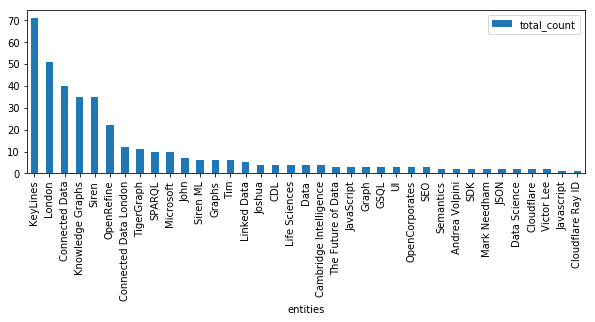

In [0]:
# Plotting a bar chart with the top 50

top50 = df_new_filtered.head(50)
plt.rcParams['figure.figsize'] = (10,3)

top50.plot(x ='entities', y='total_count', kind='bar')


### Top 50 people

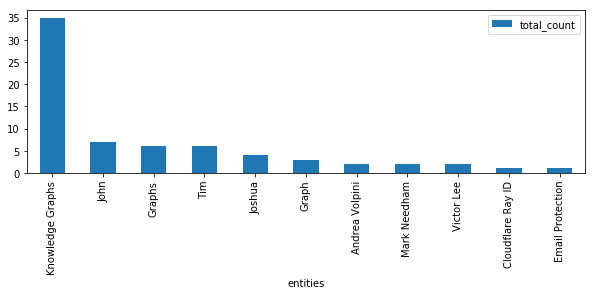

In [0]:
top_people = df_new[df_new['types'] == 'PERSON'].groupby('entities')['total'].sum().nlargest(50).reset_index(name='total_count')
top_people.plot(x ='entities', y='total_count', kind='bar')
                  

### Top 50 places (*countries, cities, states*)

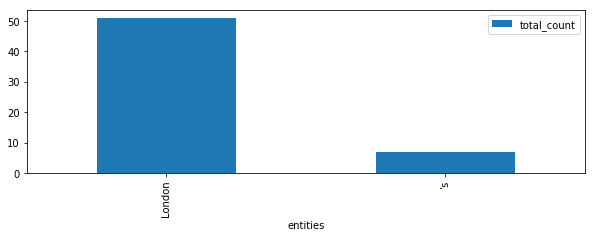

In [0]:
top_places = df_new[df_new['types'] == 'GPE'].groupby('entities')['total'].sum().nlargest(50).reset_index(name='total_count')
top_places.plot(x ='entities', y='total_count', kind='bar')

### Top 50 organizations


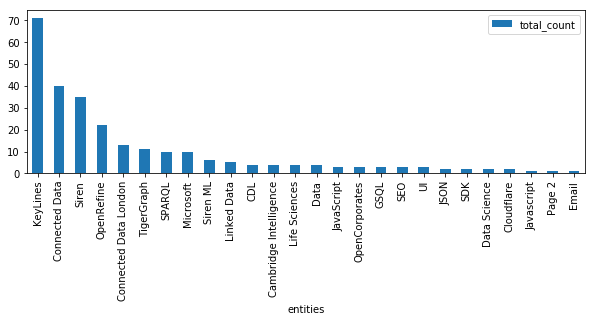

In [0]:
top_org = df_new[df_new['types'] == 'ORG'].groupby('entities')['total'].sum().nlargest(50).reset_index(name='total_count')
top_org.plot(x ='entities', y='total_count', kind='bar')

### Top named documents made into law

In [0]:
top_law = df_new[df_new['types'] == 'LAW'].groupby('entities')['total'].sum().nlargest(10).reset_index(name='total_count')
top_law.plot(x ='entities', y='total_count', kind='bar')

# License

MIT License

Copyright (c) 2019 Andrea Volpini, WordLift

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.